# MoBioFP - Object Detection (Ultralytics YOLOv8)

## Install Additional Python Libraries

In [ ]:
%pip install imutils rembg ultralytics fingerprint_enhancer fingerprint_feature_extractor

## Import Python Libraries

In [2]:
import cv2
import os
import math
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fingerprint_enhancer
import fingerprint_feature_extractor

from rembg import remove
from PIL import Image
from ultralytics import YOLO
# from google.colab import drive

## Global Constants

In [3]:
# GDRIVE_DIR = "/content/drive"
# GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
# GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/mobiofp/datasets/IIITD"
GDRIVE_YOLO_MODEL = "../models/yolo8n256-v1/arm64/weights/best.pt"

## Load Custom Pre-trained Model

In [4]:
model = YOLO(GDRIVE_YOLO_MODEL)

## Read Random Input Image

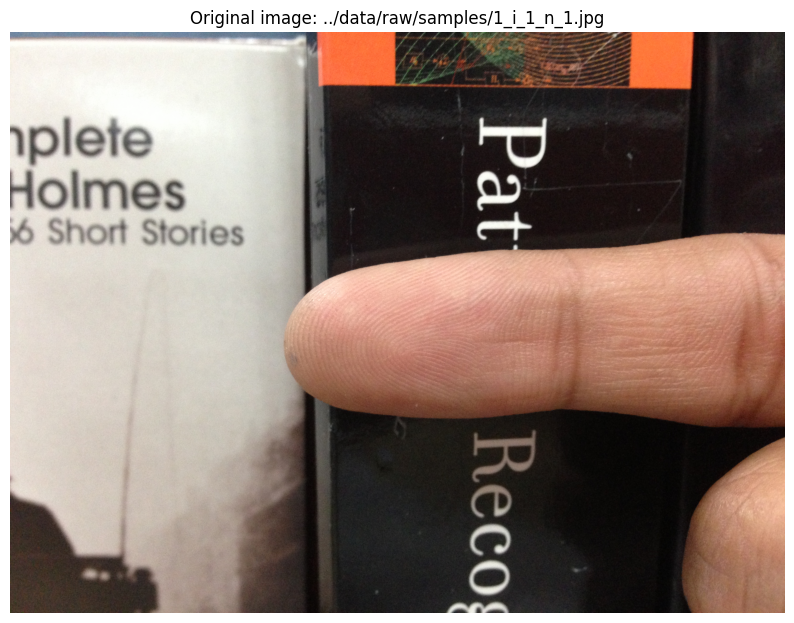

../data/raw/samples/1_i_1_n_1.jpg


In [5]:
# BACKGROUND_CLASSES = ['Natural', 'White']
# ILLUMINATES_CLASSES = ['Indoor', 'Outdoor']
# RANDOM_CLASS = GDRIVE_DATA_DIR + '/' + np.random.choice(BACKGROUND_CLASSES) + '/' + np.random.choice(ILLUMINATES_CLASSES) + '/'
# RANDOM_IMAGE_PATH = RANDOM_CLASS + np.random.choice(os.listdir(RANDOM_CLASS))
RANDOM_IMAGE_PATH = "../data/raw/samples/1_i_1_n_1.jpg"

image = cv2.imread(RANDOM_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(f'Original image: {RANDOM_IMAGE_PATH}')
plt.axis('off')
plt.show()

print(RANDOM_IMAGE_PATH)


## Fingertip Object Detection

In [6]:
results = model(image)[0]
box_xyxy = results.boxes.xyxy[0].int().cuda().cpu().numpy()

print(f"\nPredicted box: {box_xyxy}")


0: 480x640 2 fingertips, 52.0ms
Speed: 2.5ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
x, y, w, h = box_xyxy
image_box = image.copy()
cv2.rectangle(image_box, (x, y), (w, h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_box)
plt.title('Bounding box')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
fingertip = image[y:h, x:w]

plt.figure(figsize=(10, 10))
plt.imshow(fingertip)
plt.title('Final fingertip')
plt.axis('off')
plt.show()

## Fingertip Background Removal

In [ ]:
from rembg import remove

fingertip_mask = remove(fingertip, only_mask=True)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
fingertip_mask = cv2.morphologyEx(fingertip_mask, cv2.MORPH_OPEN, kernel, iterations=2)
fingertip_mask = cv2.GaussianBlur(fingertip_mask, (5, 5), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_DEFAULT)
fingertip_mask = np.where(fingertip_mask < 127, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(fingertip, cmap="gray")
plt.title('Original fingertip')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(fingertip_mask, cmap="gray")
plt.title("Binary Mask: Baground Removal")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.bitwise_and(fingertip, fingertip, mask=fingertip_mask))
plt.title("Fingertip with background removed")
plt.axis('off')
plt.tight_layout()
plt.show()

fingertip = cv2.bitwise_and(fingertip, fingertip, mask=fingertip_mask)

## Fingertip Orientation

In [ ]:
# Convert the fingertip to grayscale
fingertip_gray = cv2.cvtColor(fingertip, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(fingertip_gray, cmap="gray")
plt.title("Fingertip Grayscale:" + str(fingertip_gray.shape))

plt.subplot(1, 2, 2)
hist = cv2.calcHist([fingertip_gray], [0], None, [256], [0, 256])
hist /= hist.sum()
plt.plot(hist)
plt.xlim([0, 256])
plt.title("Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
def getOrientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    angle = math.atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians

    return angle

In [ ]:
# Find contours in the fingertip grayscale image
contours, _ = cv2.findContours(fingertip_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Sort the contours by area
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Find the contour with the largest area
largest_contour = contours[0]

# Find the orientation of the largest contour
angle = getOrientation(largest_contour, fingertip_gray)

# If the angle is negative, make it positive
if angle < 0:
    angle = 90 + angle

# Rotate the fingertip
fingertip_rotated = imutils.rotate_bound(fingertip, angle)
fingertip_gray_rotated = imutils.rotate_bound(fingertip_gray, angle)
fingertip_mask_rotated = imutils.rotate_bound(fingertip_mask, angle)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(fingertip_rotated)
plt.title('Original fingertip rotated')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(fingertip_gray_rotated, cmap="gray")
plt.title("Gray fingertip rotated")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(fingertip_mask_rotated, cmap="gray")
plt.title("Binary Mask rotated")
plt.axis('off')
plt.tight_layout()
plt.show()

## Fingertip Gamma Correction

In [ ]:
from skimage import data, img_as_float
from skimage import exposure

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Gamma
gamma_corrected = exposure.adjust_gamma(fingertip_gray_rotated, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(fingertip_gray_rotated, 1)

# Display results
fig = plt.figure(figsize=(20, 10))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(fingertip_gray_rotated, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

fingertip_gray_rotated = logarithmic_corrected

## Fingertip Enhancement

In [ ]:
# Normalize the image
normalized = cv2.normalize(fingertip_gray_rotated, None, 0, 255, cv2.NORM_MINMAX)

# Apply bilateral filter
bilateral = cv2.bilateralFilter(normalized, 7, 50, 50)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(bilateral)

plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(fingertip_gray_rotated, cmap="gray")
plt.title('Original fingertip rotated')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(normalized, cmap="gray")
plt.title("Normalized")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(bilateral, cmap="gray")
plt.title("Bilateral")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(clahe, cmap="gray")
plt.title("CLAHE")
plt.axis('off')
plt.tight_layout()
plt.show()

fingertip_gray_rotated = clahe

## Adaptive Thresholding

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(fingertip_gray_rotated, cmap="gray")
plt.title("Fingertip Grayscale:" + str(fingertip_gray_rotated.shape))

plt.subplot(1, 2, 2)
hist, bins = np.histogram(fingertip_gray_rotated.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(fingertip_gray_rotated.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("Histogram")
plt.tight_layout()
plt.show()

In [ ]:
thresh_mean = cv2.adaptiveThreshold(fingertip_gray_rotated, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(fingertip_gray_rotated, cmap="gray")
plt.title('Original fingertip rotated')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(thresh_mean, cmap="gray")
plt.title("Adaptive threshold mean")
plt.axis('off')
plt.tight_layout()
plt.show()

thresh = thresh_mean

## Gabor Filters (TO BE REVIEWED!)

In [ ]:
_sigma_conv = (3.0/2.0)/((6*math.log(10))**0.5)
# sigma is adjusted according to the ridge period, so that the filter does not contain more than three effective peaks
def _gabor_sigma(ridge_period):
    return _sigma_conv * ridge_period

def _gabor_size(ridge_period):
    p = int(round(ridge_period * 2 + 1))
    if p % 2 == 0:
        p += 1
    return (p, p)

def gabor_kernel(period, orientation):
    f = cv2.getGaborKernel(_gabor_size(period), _gabor_sigma(period), np.pi/2 - orientation, period, gamma = 1, psi = 0)
    f /= f.sum()
    f -= f.mean()
    return f

def from_amt_to_scan(image):
    """heavily from https://colab.research.google.com/drive/1u5X8Vg9nXWPEDFFtUwbkdbQxBh4hba_M"""

    fingerprint = image

    # Calculate the local gradient (using Sobel filters)
    gx, gy = cv2.Sobel(fingerprint, cv2.CV_32F, 1, 0), cv2.Sobel(fingerprint, cv2.CV_32F, 0, 1)

    # Calculate the magnitude of the gradient for each pixel
    gx2, gy2 = gx**2, gy**2

    W = (29, 29) # (23, 23)
    gxx = cv2.boxFilter(gx2, -1, W, normalize = False)
    gyy = cv2.boxFilter(gy2, -1, W, normalize = False)
    gxy = cv2.boxFilter(gx * gy, -1, W, normalize = False)
    gxx_gyy = gxx - gyy
    gxy2 = 2 * gxy

    orientations = (cv2.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction

    # _region = fingerprint[10:90,80:130]
    center_h = fingerprint.shape[0]//3
    center_w = fingerprint.shape[1]//2
    #_region = fingerprint[center_h-40:center_h+40, center_w-25:center_w+25]
    region = fingerprint[center_h-40:center_h+40, center_w+10:center_w+60]

    # before computing the x-signature, the region is smoothed to reduce noise
    smoothed = cv2.blur(region, (5,5), -1)
    xs = np.sum(smoothed, 1) # the x-signature of the region

    # Find the indices of the x-signature local maxima
    local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

    # Calculate all the distances between consecutive peaks
    distances = local_maxima[1:] - local_maxima[:-1]

    # Estimate the ridge line period as the average of the above distances
    ridge_period = np.average(distances)

    # Create the filter bank
    or_count = 8
    gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

    # Filter the whole image with each filter
    # Note that the negative image is actually used, to have white ridges on a black background as a result!!
    nf = 255-fingerprint
    all_filtered = np.array([cv2.filter2D(nf, cv2.CV_32F, f) for f in gabor_bank])

    y_coords, x_coords = np.indices(fingerprint.shape)
    # For each pixel, find the index of the closest orientation in the gabor bank
    orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
    # Take the corresponding convolution result for each pixel, to assemble the final result
    filtered = all_filtered[orientation_idx, y_coords, x_coords]
    # Convert to gray scale and apply the mask
    enhanced = np.clip(filtered, 0, 255).astype(np.uint8)

    return enhanced

In [ ]:
thresh_resized = imutils.resize(thresh, width=400)
# GABOR_IMAGE_SHAPE = (400, 840)
# thresh_resized = cv2.resize(thresh, GABOR_IMAGE_SHAPE, interpolation=cv2.INTER_AREA)
enhanced_gabor = from_amt_to_scan(thresh_resized)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(thresh_resized, cmap="gray")
plt.title('Adaptive threshold resized: ' + str(thresh_resized.shape))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_gabor, cmap="gray")
plt.title("Fingerprint Enhanced with Gabor filter")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
enhanced_fingerprint = fingerprint_enhancer.enhance_Fingerprint(enhanced_gabor)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(enhanced_gabor, cmap="gray")
plt.title('Enhanced Gabor')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_fingerprint, cmap="gray")
plt.title("Enhanced Fingerprint")
plt.axis('off')
plt.tight_layout()
plt.show()

## Fingerprint Matching with ORB

In [ ]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(enhanced_fingerprint,None)
# compute the descriptors with ORB
kp, des = orb.compute(enhanced_fingerprint, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(enhanced_fingerprint, kp, None, color=(0,255,0), flags=0)

plt.figure(figsize=(10, 10))
plt.imshow(img2, cmap="gray")
plt.title("ORB Detector")
plt.show()

## Fingerprint Feature Extractor

In [ ]:
terminations, bifurcations = fingerprint_feature_extractor.extract_minutiae_features(
    enhanced_fingerprint,
    spuriousMinutiaeThresh=10,

)

print(f"Terminations: {len(terminations)}")
print(f"Bifurcations: {len(bifurcations)}")